In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import scipy as sp
import pandas as pd
import pickle

import path
path.path = path.Path
from pyqt_fit import kde,kde_methods

Warning, cannot import Cython kernel functions, pure python functions will be used instead


In [12]:
# break-up velocity: Fuerza Centrifuga vs Gravitacional

vel_breakup = np.sqrt(c.G * 10*u.Mjup / (1.7* u.Rjup))
vel_breakup = vel_breakup.to(u.km/u.s)

print('V_breakup = '+ str(vel_breakup))
print('AB Pic b is orbiting at '+str(73*(u.km/u.s)/vel_breakup)+'% of its break-up velocity')



V_breakup = 102.09677791738046 km / s
AB Pic b is orbiting at 0.7150078728152774% of its break-up velocity


# iii/ Orbital inclination / Obliquity derivation

We found the publication of Zhou et al. (2019) where through the lightcurve variability they estimate the rotation period of AB Pic b to be 2.1 hr.

https://iopscience.iop.org/article/10.3847/1538-3881/ab037f/pdf

Since there is already a reliable estimation on the rotation period, the previouse estimations are not the key parameter we can push. We decided to go for the obliquity of the planet, given our vsini value and the P_rotation from Zhou

For this we follow the procedure showed in Bryan et al. (2021), section 3.5.

https://doi.org/10.3847/1538-3881/ac1bb1


/var/folders/8z/7v6zvrh56pv_bj45q5fh34540000gn/T/ipykernel_12023/914505431.py:20: RuntimeWarning: invalid value encountered in arcsin
  angles = np.arcsin(sin_i.value)


inc_planet ~ 46.800000000000004
Size initial sample = 2870
Maximum velocity with P>Pb = 101.37252448138145 km / s
Size new sample = 1477 (vsini < v < vb)
inc_planet ~ 46.800000000000004


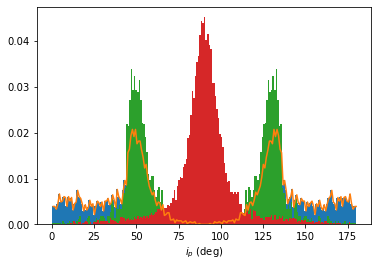

In [13]:
# FIRST THE IMPORT OF THE DATA 

# posteriors B7 fit (Radius and vsini)
file = '/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.pic'

with open(file, 'rb') as f:
    res  = pickle.load(f)
    samp = res.samples
    weig = res.weights
    
vsini   = samp[:,6] * u.km/u.s    
radius  = samp[:,4] * u.Rjup
Prot_lc = 2.12      * u.hr

# computing sin(i) distribution
v = (2*np.pi*radius/Prot_lc).si  # km/s
sin_i = (vsini/(v)).si

# converting to angles
angles = np.arcsin(sin_i.value)
angles = np.concatenate((angles, np.pi-angles))

angles_density, angles_bins, patches = plt.hist(angles*180/np.pi,bins=200, density=True,range=(0,180))
plt.plot(angles_bins[1:],angles_density)

# geting the maximal value out
bin_max = np.where(angles_density == angles_density.max())
inc_planet = angles_bins[bin_max]
print('inc_planet ~',inc_planet[0])




#### Laetitia

pb = 2*np.pi*(radius**(3/2))/np.sqrt(c.G*10*u.Mjup) # break-up period (s)

print(f"Size initial sample = {len(v)}")
sample = (Prot_lc > pb) # Removing solutions above the break-up velocity
vsini = vsini[sample]
v = (v[sample]).to(u.km/u.s)

vmax = v.max()
print(f"Maximum velocity with P>Pb = {vmax}")

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip.value, np.pi-ip.value))
nsample *= 2

angles_density, angles_bins, patches = plt.hist(ip*180/np.pi,bins=200, density=True,range=(0,180))

bin_max = np.where(angles_density == angles_density.max())
inc_planet = angles_bins[bin_max]
print('inc_planet ~',inc_planet[0])

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()
plt.hist(io*180/np.pi,bins=200, density=True,range=(0,180))

plt.xlabel(r'$i_p$ (deg)')
plt.show()



Size initial sample = 2870
Maximum velocity with P>Pb = 101.37252448138145 km/s
Size initial sample = 1508
Size new sample = 1477 (vsini < v < vb)


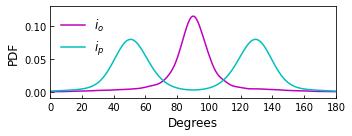

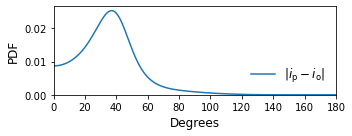

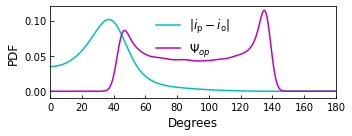

In [25]:
G = 6.67e-20 #km**3 kg**-1 s**-2
rjup = 71492 #km
mjup = 1.898e27 #kg
h2s = 3600 #sec
dr = np.pi/180

file  = open("/Users/pulux/Desktop/exoAtmospheres/code_exoAtm/data/result_nestle_ABPicb_B7.txt", "r")
data = np.loadtxt(file, skiprows=1)
file.close()

radius = data[:,4]*rjup #km
vsini = data[:,6] #km/s

p = 2.12*h2s #s
v = 2*np.pi*radius/p # km/s

# break-up period (s)
mp = 10*mjup #kg
pb = 2*np.pi*(radius**(3/2))/np.sqrt(G*mp) 

# Removing solutions above the break-up velocity
print(f"Size initial sample = {len(v)}")
sample = (p > pb) 
vsini = vsini[sample]
v = v[sample]

vmax = v.max()
print(f"Maximum velocity with P>Pb = {vmax} km/s")

######
# Here equation 10 of Bryan et al. 2021

lv = kde.KDE1D(v)
lu = kde.KDE1D(vsini)

nv = 200
vrange = np.linspace(0, vmax, nv)
i = np.linspace(0, np.pi, 200)

pcosi = np.zeros_like(i) # PDF of cos(ip)
for j, ci in enumerate(np.cos(i)):
    int_dv = lv(vrange)*lu(vrange*np.sqrt(1-ci*ci))
    pcosi[j] = np.trapz(int_dv, vrange)

# PDF of ip
pi = pcosi*np.sin(i) 

int_pi = np.trapz(pi, i) # normalization factor
pi /= int_pi

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size initial sample = {len(v)}")
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip, np.pi-ip))
nsample *= 2

#################################
##################################
###################################

lo = kde.KDE1D(io, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io
pdf_ip = kde.KDE1D(ip, lower=0., upper=2*np.pi, method=kde_methods.cyclic) # PDF of io

### Here I compute proba(l) = proba(|io-ip|) = int pi(ip)*(pio(ip+l)+pio(ip-l))/2 (combination of probability functions)
l = np.linspace(0, np.pi, 200)
pl = np.zeros_like(l)
i = np.linspace(0, np.pi, 200)

def pio(x): # PDF of io, being sure it is defined everywhere (not only [0, pi])
    if np.isscalar(x):
        if (x > 0) and (x < np.pi):
            return(lo(x))
        else:
            return(0)
    else:
        res = np.zeros_like(x)
        for k, xx in enumerate(x):
            if (xx > 0) and (xx < np.pi):
                res[k] = lo(xx)
            else:
                res[k] = 0
        return(res)

for j, la in enumerate(l):
    int_dl = pi*(pio(i-la)+pio(i+la))/2
    pl[j] = np.trapz(int_dl, i)

int_pl = np.trapz(pl, l)
pl /= int_pl

################################################
################################################
plt.figure(figsize=(5,2))
#a_ip, ab_ip, pat_ip = plt.hist(ip*180/np.pi,bins=100, density=True,range=(0,180), label=r'$i_p$', color='c',histtype='step')

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()
#a_io, ab_io, pat_io = plt.hist(io*180/np.pi,bins=100, density=True,range=(0,180), label=r'$i_o$', color='m',histtype='step')

plt.plot(l*180/np.pi,pio(l)*0.05, label=r'$i_o$', color='m')
plt.plot(l*180/np.pi,pdf_ip(l)*0.08, label=r'$i_p$', color='c')

plt.legend(frameon=False,fontsize=12, loc=2)
plt.ylabel('PDF',fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
plt.tick_params(direction='in')
plt.xlim(0,180)
plt.ylim(-0.01,0.13)
plt.tight_layout()
plt.savefig('inc_op.pdf')
plt.show()

######################## ########################
################################################


######################## ########################
################################################




def phi_op_dist(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)
    
    dist_1 = arg_2*np.cos(Omega_orb-Omega_pl)
    
    phi_op = np.arccos(arg_1 + dist_1)
    return phi_op


conv = np.pi/180

l = np.linspace(0, np.pi, 200)
inc_orbit = 90*conv #pio(l) # ±12
Omega_orb = -5 #± 13 ± 180
Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=100000)
phi_op = phi_op_dist(inc_planet[0]*conv, inc_orbit, Omega_pl_dist*conv, Omega_orb*conv)



# plot projected obliquity
plt.figure(figsize=(5,2))


####
plt.plot(l/dr, pl*dr*4, label=r"$|i_{\rm p} - i_{\rm o}|$", color='c')
#plt.plot(l/dr,pio(l/dr)*0.1, label="inc orit")

#plt.hist(phi_op/conv, bins=100, density=True,range=(0,180), label=r'$\Psi_{op}$', color='m',histtype='step')
ohi_op_den = kde.KDE1D(phi_op, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io
plt.plot(l/dr,ohi_op_den(l)*0.1, color='m', label=r'$\Psi_{op}$')



plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.ylabel("PDF",fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
plt.tick_params(direction='in')
plt.xlim(0,180)
plt.ylim(-0.01,0.12)
plt.legend(frameon=False,fontsize=12,loc=9)
plt.tight_layout()
plt.savefig('obl_op.pdf')
plt.show()

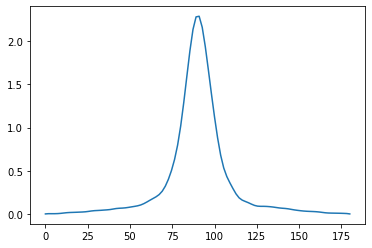

In [59]:
plt.plot(l*180/np.pi,pio(l))

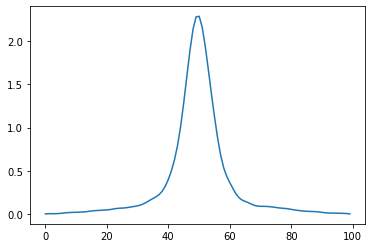

In [100]:
plt.plot(inc_orbit)


In [105]:
ip

array([0.62770839, 0.60174873, 0.36964594, ..., 2.31499374, 2.14848374,
       2.35790925])

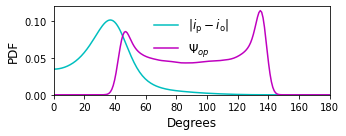

In [17]:
def phi_op_dist(inc_pl, inc_orbit, Omega_pl, Omega_orb):
    arg_1 = np.cos(inc_pl)*np.cos(inc_orbit) 
    arg_2 = np.sin(inc_pl)*np.sin(inc_orbit)
    
    dist_1 = arg_2*np.cos(Omega_orb-Omega_pl)
    
    phi_op = np.arccos(arg_1 + dist_1)
    return phi_op


conv = np.pi/180

l = np.linspace(0, np.pi, 200)
inc_orbit = 90*conv #pio(l) # ±12
Omega_orb = -5 #± 13 ± 180
Omega_pl_dist = np.random.uniform(low=0.0, high=180, size=100000)
phi_op = phi_op_dist(inc_planet[0]*conv, inc_orbit, Omega_pl_dist*conv, Omega_orb*conv)



# plot projected obliquity
plt.figure(figsize=(5,2))


####
plt.plot(l/dr, pl*dr*4, label=r"$|i_{\rm p} - i_{\rm o}|$", color='c')
#plt.plot(l/dr,pio(l/dr)*0.1, label="inc orit")

#plt.hist(phi_op/conv, bins=100, density=True,range=(0,180), label=r'$\Psi_{op}$', color='m',histtype='step')
ohi_op_den = kde.KDE1D(phi_op, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io
plt.plot(l/dr,ohi_op_den(l)*0.1, color='m', label=r'$\Psi_{op}$')



plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.ylabel("PDF",fontsize=12)
plt.xlabel(r'Degrees',fontsize=12)
plt.xlim(0,180)
plt.legend(frameon=False,fontsize=12,loc=9)
plt.tight_layout()
plt.savefig('obl_op.pdf')
plt.show()

In [123]:
a_ip,inc_planet[0]*conv,inc_planet[0]

(array([0.00037614, 0.00037614, 0.00037614, 0.00037614, 0.00018807,
        0.00056421, 0.00037614, 0.00018807, 0.00094034, 0.00094034,
        0.00018807, 0.00094034, 0.00112841, 0.00018807, 0.00112841,
        0.00094034, 0.00188069, 0.00075228, 0.00188069, 0.00413752,
        0.00282103, 0.00413752, 0.00376138, 0.00620627, 0.01485744,
        0.02426089, 0.03159558, 0.0308433 , 0.03027909, 0.02463703,
        0.02049951, 0.01335289, 0.01015572, 0.00902731, 0.00677048,
        0.00658241, 0.005454  , 0.00263296, 0.00263296, 0.00206876,
        0.00094034, 0.00131648, 0.00112841, 0.00131648, 0.00056421,
        0.00094034, 0.00094034, 0.        , 0.00018807, 0.        ,
        0.        , 0.00018807, 0.        , 0.00094034, 0.00094034,
        0.00056421, 0.00131648, 0.00112841, 0.00131648, 0.00094034,
        0.00206876, 0.00263296, 0.00263296, 0.005454  , 0.00658241,
        0.00677048, 0.00902731, 0.01015572, 0.01335289, 0.02049951,
        0.02463703, 0.03027909, 0.0308433 , 0.03

(0.0, 180.0)

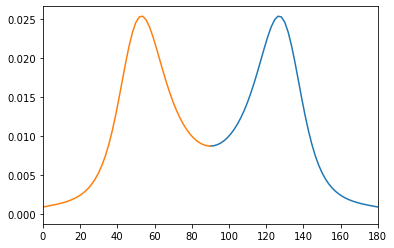

In [19]:
plt.plot(l/dr+90, pl*dr, label="prior cos")
plt.plot(90-l/dr, pl*dr, label="prior cos")
plt.xlim(0,180)

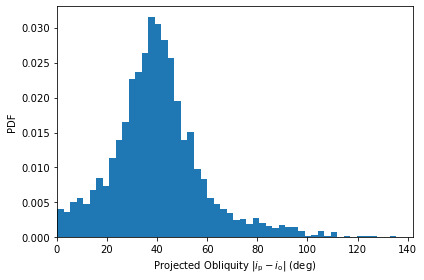

AttributeError: 'numpy.float64' object has no attribute 'value'

In [10]:

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()

if len(io) > nsample:
    io = np.random.choice(io, nsample)
else:
    nsample = len(io)
    ip = np.random.choice(ip, nsample)
lambda_no_prior = abs(io-ip) # lambda =  projected obliquity |io-ip|

dr = np.pi/180
plt.hist(lambda_no_prior/dr, bins="auto", density=True)


plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.xlabel(r"Projected Obliquity $|i_{\rm p} - i_{\rm o}|$ (deg)")
plt.ylabel("PDF")

plt.tight_layout()
plt.show()


lv = kde.KDE1D(v)
lu = kde.KDE1D(vsini)

nv = 1000
vrange = np.linspace(0, vmax.value, nv)
i = np.linspace(0, np.pi, 100)

pcosi = np.zeros_like(i) # PDF of cos(ip)
for j, ci in enumerate(np.cos(i)):
    int_dv = lv(vrange)*lu(vrange*np.sqrt(1-ci*ci))
    pcosi[j] = np.trapz(int_dv, vrange)

pi = pcosi*np.sin(i) # PDF of ip

int_pi = np.trapz(pi, i) # normalization factor
pi /= int_pi

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size initial sample = {len(v)}")
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip, np.pi-ip))
nsample *= 2

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()

lo = kde.KDE1D(io, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io

### Here I compute proba(l) = proba(|io-ip|) = int pi(ip)*(pio(ip+l)+pio(ip-l))/2 (combination of probability functions)
l = np.linspace(0, np.pi, 100)
pl = np.zeros_like(l)
i = np.linspace(0, np.pi, 100)

def pio(x): # PDF of io, being sure it is defined everywhere (not only [0, pi])
    if np.isscalar(x):
        if (x > 0) and (x < np.pi):
            return(lo(x))
        else:
            return(0)
    else:
        res = np.zeros_like(x)
        for k, xx in enumerate(x):
            if (xx > 0) and (xx < np.pi):
                res[k] = lo(xx)
            else:
                res[k] = 0
        return(res)

for j, la in enumerate(l):
    int_dl = pi*(pio(i-la)+pio(i+la))/2
    pl[j] = np.trapz(int_dl, i)

int_pl = np.trapz(pl, l)
pl /= int_pl

# plot projected obliquity
plt.plot(l/dr, pl*dr, label="prior cos")

plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.xlabel(r"Projected Obliquity $|i_{\rm p} - i_{\rm o}|$ (deg)")
plt.ylabel("PDF")

plt.tight_layout()
plt.show()

In [20]:
p = (2.12*u.hr).to(u.s) #*h2s #s
v = 2*np.pi*radius/p # km/s

mp = 10*mjup #kg
pb = 2*np.pi*(radius**(3/2))/np.sqrt(G*mp) # break-up period (s)

print(f"Size initial sample = {len(v)}")
sample = (p > pb) # Removing solutions above the break-up velocity
vsini = vsini[sample]
v = v[sample]

vmax = v.max()
print(f"Maximum velocity with P>Pb = {vmax} km/s")

lv = kde.KDE1D(v)
lu = kde.KDE1D(vsini)

nv = 1000
vrange = np.linspace(0, vmax, nv)
i = np.linspace(0, np.pi, 100)

pcosi = np.zeros_like(i) # PDF of cos(ip)
for j, ci in enumerate(np.cos(i)):
    int_dv = lv(vrange)*lu(vrange*np.sqrt(1-ci*ci))
    pcosi[j] = np.trapz(int_dv, vrange)

pi = pcosi*np.sin(i) # PDF of ip

int_pi = np.trapz(pi, i) # normalization factor
pi /= int_pi

sample = (vsini < v)
nsample = np.sum(sample)
print(f"Size initial sample = {len(v)}")
print(f"Size new sample = {nsample} (vsini < v < vb)")
sini = vsini/v
ip = np.arcsin(sini[sample])
ip = np.concatenate((ip, np.pi-ip))
nsample *= 2

file = open("io.dat", "r")
io = np.loadtxt(file, skiprows=1)
file.close()

lo = kde.KDE1D(io, lower=0., upper=np.pi, method=kde_methods.cyclic) # PDF of io

### Here I compute proba(l) = proba(|io-ip|) = int pi(ip)*(pio(ip+l)+pio(ip-l))/2 (combination of probability functions)
l = np.linspace(0, np.pi, 100)
pl = np.zeros_like(l)
i = np.linspace(0, np.pi, 100)

def pio(x): # PDF of io, being sure it is defined everywhere (not only [0, pi])
    if np.isscalar(x):
        if (x > 0) and (x < np.pi):
            return(lo(x))
        else:
            return(0)
    else:
        res = np.zeros_like(x)
        for k, xx in enumerate(x):
            if (xx > 0) and (xx < np.pi):
                res[k] = lo(xx)
            else:
                res[k] = 0
        return(res)

for j, la in enumerate(l):
    int_dl = pi*(pio(i-la)+pio(i+la))/2
    pl[j] = np.trapz(int_dl, i)

int_pl = np.trapz(pl, l)
pl /= int_pl

# plot projected obliquity
plt.plot(l/dr, pl*dr, label="prior cos")

plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.xlabel(r"Projected Obliquity $|i_{\rm p} - i_{\rm o}|$ (deg)")
plt.ylabel("PDF")

plt.tight_layout()
plt.show()

NameError: name 'mjup' is not defined

# RV estimation

 radial velocity semi-amplitude 
 
 K = (vr,max − vr,min )/2:

In [18]:

ecc  = 0.1
inc  = np.pi/2
m2   = 6 # u.Mjup
m1   = 0.86

dist = 2 # au

K = (28.4329 * u.m / u.s) / (np.sqrt(1-ecc**2)) * (m2*u.Mjup * np.sin(inc))/u.Mjup * ((m1*u.Msun + m2*u.Mjup)/u.Msun)**(-1/2) * (dist)**(-1/2)
K = K.to(u.m/u.s)


dist2 = 10 # au

K2 = (28.4329 * u.m / u.s) / (np.sqrt(1-ecc**2)) * (m2*u.Mjup * np.sin(inc))/u.Mjup * ((m1*u.Msun + m2*u.Mjup)/u.Msun)**(-1/2) * (dist2)**(-1/2)
K2 = K2.to(u.m/u.s)

print(K ,K2)


############ 1 sigma inc
ecc  = 0.3
inc  = 78/180*np.pi

m2   = 6 # u.Mjup
m1   = 0.86

dist = 2 # au

K = (28.4329 * u.m / u.s) / (np.sqrt(1-ecc**2)) * (m2*u.Mjup * np.sin(inc))/u.Mjup * ((m1*u.Msun + m2*u.Mjup)/u.Msun)**(-1/2) * (dist)**(-1/2)
K = K.to(u.m/u.s)


dist2 = 10 # au

K2 = (28.4329 * u.m / u.s) / (np.sqrt(1-ecc**2)) * (m2*u.Mjup * np.sin(inc))/u.Mjup * ((m1*u.Msun + m2*u.Mjup)/u.Msun)**(-1/2) * (dist2)**(-1/2)
K2 = K2.to(u.m/u.s)

print(K ,K2)

130.3014323810956 m / s 58.2725720739444 m / s
132.93841149275391 m / s 59.451864983727404 m / s
